# Medical insurance Portfolio project
### Project goals: 
* Analyze our data
* Find out the main features that influence the medical insurance charges
* Model these features to predict changes in charges

### libraries used in this project:

In [117]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # remove seaborn future warning above plots

## dataset exploration/overview:

In [113]:
insurance_df = pd.read_csv("insurance.csv") #load dataset

In [114]:
print(insurance_df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [82]:
print(insurance_df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


* age starts at 18, stops at 64 -> dataset of potentialy working adults
* dataset has 1338 samples --> fairly small, we have to keep that in mind

## analysing single features checking if data is representative:

### statistic functions:

In [83]:
def mean_std(collumn_name, dataframe, distplot = False): # function to calculate the mean and the standart deviation
    if distplot == True:
        sns.distplot(dataframe[collumn_name])
    else:
        sns.histplot(dataframe[collumn_name])
    mean = dataframe[collumn_name].mean()
    median = dataframe[collumn_name].median()
    plt.axvline(mean, color='r', linestyle='solid', linewidth=1, label="Mean")
    plt.axvline(median, color='y', linestyle='solid', linewidth=1, label="Median")
    plt.legend()
    plt.show()
    std = dataframe[collumn_name].std()
    print(f"The mean {collumn_name} is {mean} and the standard deviation is {std}.")
    print(f"{collumn_name} distribution:")
    
percentage = lambda number, total: (number/total)*100 # formulat to calculate percentages

### age:

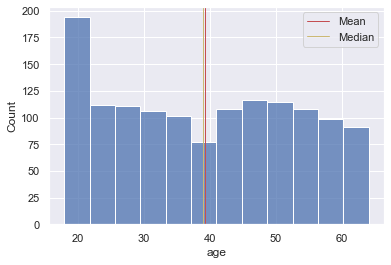

The mean age is 39.20702541106129 and the standard deviation is 14.049960379216154.
age distribution:


In [84]:
mean_std("age", insurance_df)

#### interpretation:

* mean age fits to the number other studies found for the mean working-age in the Us, 
* standard deviation is high -> representative of different age groups
* spike at 20 

### sex:

In [85]:
sex_proportions = insurance_df["sex"].value_counts(normalize=True).reset_index().rename(columns={"index":"sex", "sex":"proportion"},errors="raise") # calculate proportions 
print(sex_proportions)

      sex  proportion
0    male    0.505232
1  female    0.494768


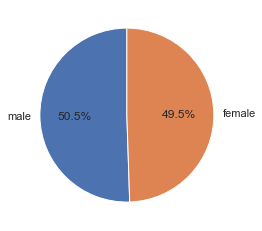

In [86]:
plt.pie(sex_proportions["proportion"], labels=sex_proportions["sex"],autopct='%1.1f%%', startangle=90)
plt.show()

#### Interpretation:

* evenly spread
* represenative of both sexes

### BMI:

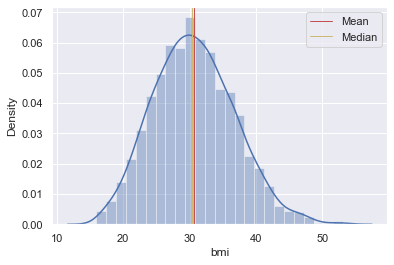

The mean bmi is 30.66339686098655 and the standard deviation is 6.098186911679014.
bmi distribution:


In [87]:
mean_std("bmi", insurance_df, distplot=True)

#### Interpretation:

* mean BMI is in the overweight range
* histogram is symetric and unimodal
* standard deviation is high due to extremes above 50 BMI and under 20
    * --> representative of a broad range of body types

### Children:

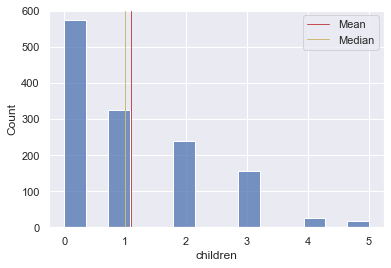

The mean children is 1.0949177877429 and the standard deviation is 1.205492739781914.
children distribution:


In [88]:
mean_std("children", insurance_df)

#### No child vs. one or more children:

In [89]:
insurance_df["child_no_child"] = insurance_df["children"].apply(lambda x: "no child" if x == 0 else "one or more children") # create new collumn containing information about wether the person has children or not

In [90]:
children_proportions = insurance_df["child_no_child"].value_counts(normalize=True).reset_index().rename(columns={"child_no_child":"proportion", "index":"children"}) #calculate proportions
print(children_proportions)

               children  proportion
0  one or more children    0.571001
1              no child    0.428999


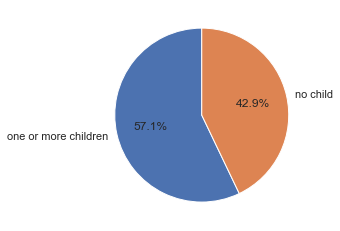

In [91]:
plt.pie(children_proportions["proportion"], labels=children_proportions["children"],autopct='%1.1f%%', startangle=90)
plt.show()

#### Interpretation:

* the average number of children in this dataset is 1.1, with a standard deviation of 1.2 -> low due to the high amount of entries with no child
* the histogram has a right-skew, it's clear that there are fewer and fewer people with growing amount of children
    * --> representative of the population regarding the trend BUT not regarding samples with a higher amount of children due to the low number of entries 

### Region: 

In [92]:
region_proportions = insurance_df["region"].value_counts(normalize=True).reset_index().rename(columns={"index":"region", "region":"proportion"}) # calculate proportions
print(region_proportions)

      region  proportion
0  southeast    0.272048
1  southwest    0.242900
2  northwest    0.242900
3  northeast    0.242152


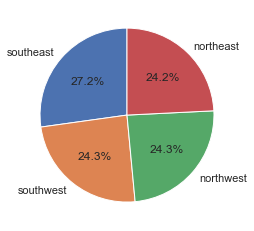

In [93]:
plt.pie(region_proportions["proportion"], labels=region_proportions["region"],autopct='%1.1f%%', startangle=90)
plt.show()

#### Interpretation:

* regions are evenly spread 


## Correlations
#### We want to find out which major aspects influence medical insurance charges to investigate these correlations further in the next segment:

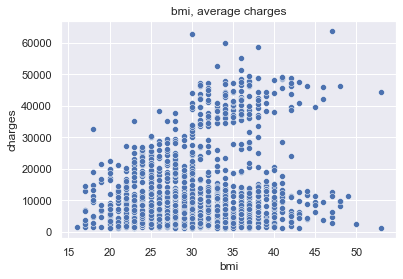

In [94]:
bmi_plot = sns.scatterplot(insurance_df["bmi"].apply(lambda x: round(x)), insurance_df["charges"])
bmi_plot.set_title("bmi, average charges")
plt.show()

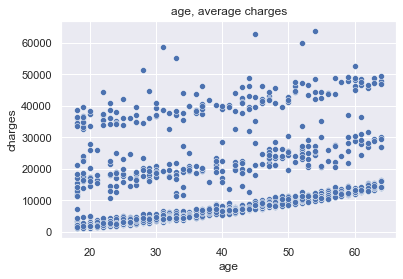

In [95]:
age_plot = sns.scatterplot(insurance_df["age"], insurance_df["charges"])
age_plot.set_title("age, average charges")
plt.show()

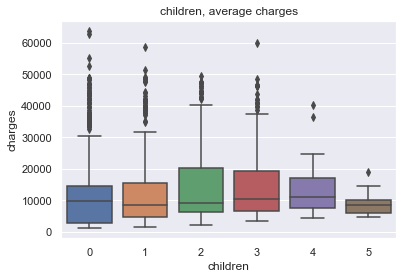

In [96]:
children_plot = sns.boxplot(insurance_df["children"], insurance_df["charges"])
children_plot.set_title("children, average charges")
plt.show()

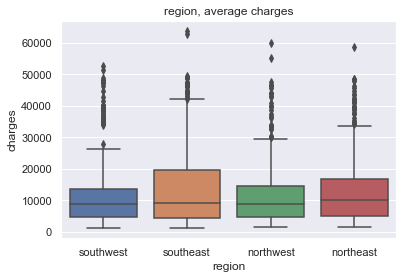

In [97]:
region_plot = sns.boxplot(insurance_df["region"], insurance_df["charges"])
region_plot.set_title("region, average charges")
plt.show()

charge difference west/east:

In [98]:
insurance_df["west_east"] = insurance_df["region"].apply(lambda x: x[-4:]) # create new collumn differenciating between just west and east
east_west_mean = insurance_df.groupby(insurance_df["west_east"]).charges.mean()
diffrence = east_west_mean["east"]-east_west_mean["west"]
print(f"the mean difference between east and west is {diffrence} dollars")

the mean difference between east and west is 1727.2761048910343 dollars


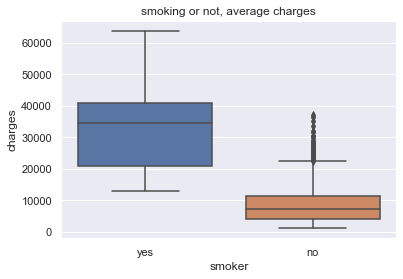

In [99]:
smoker_plot = sns.boxplot(insurance_df["smoker"], insurance_df["charges"])
smoker_plot.set_title("smoking or not, average charges")
plt.show()

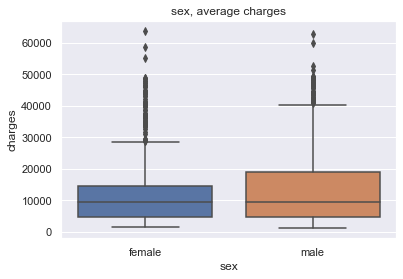

In [100]:
sex_plot = sns.boxplot(insurance_df["sex"], insurance_df["charges"])
sex_plot.set_title("sex, average charges")
plt.show()

#### heatmap displaying correlation coeficients:

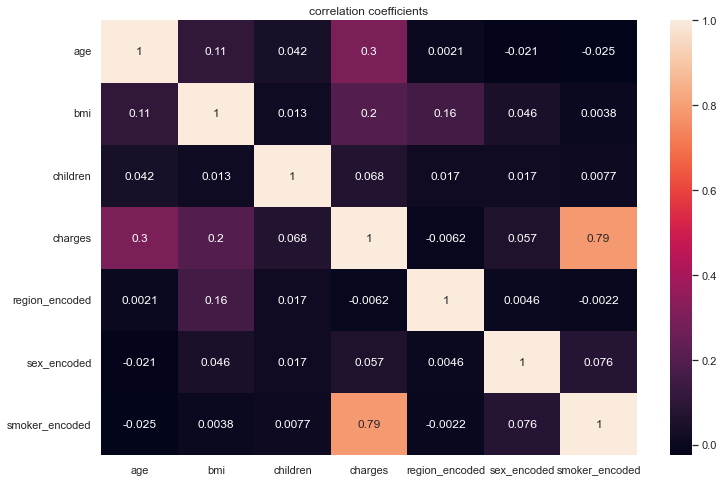

In [116]:
# turn all collumns to numeric ones
insurance_df["smoker"] = pd.Categorical(insurance_df["smoker"])
insurance_df["sex"] = pd.Categorical(insurance_df["sex"])
insurance_df["region"] = pd.Categorical(insurance_df["region"])
insurance_df["region_encoded"] = insurance_df["region"].cat.codes
insurance_df["sex_encoded"] = insurance_df["sex"].cat.codes
insurance_df["smoker_encoded"] = insurance_df["smoker"].cat.codes


plt.figure(figsize = (12,8))
corr_plot = sns.heatmap(insurance_df.corr(), annot=True)
corr_plot.set_title("correlation coefficients")
plt.show()

### Interpretation:

1. BMI: higher BMI seems to raise the charges, average looks like it follows a linear pattern, correlation coefficient of 0.2 -> visible correlation between BMI and charges
2. age: higher age seems to raise the charges, average looks like it follows a linear pattern, correlation coefficient of 0.3 -> visible correlation between age and charges
3. children: charges seem to slightly raise with growing amount of children till the third one, then they rapidly fall, extremely low correlation coefficient
    * does not seem logical, the low amount of data regarding 4 or more children might not be representative
    * not able to draw conclusions about the correlation of age and insurance charges with this dataset
4. region: slight difference in cost between the different regions, mainly between east and west (1727.28 dollars).
    * Due to the small dataset, this project is using, the difference is too small to make certain conclusions about this difference. It would have to be investigated further in another project with a larger amount of data.
5. smoker: data shows the charges being far higher for smoking people, the boxplots don't overlap, correlation coefficient of 0.79 -> high correlation
6. sex: data indicates a slight average difference between male and female. Males tend to pay higher charges

#### Main correlations:
To conclude the data on the children showed no clear pattern regarding the medical insurance charges. Sex and region showed small influences on medical insurance charges but our dataset is too small to be certain about these influences. Finally smoking, age and BMI showed clear patterns regarding the medical insurance charges, as well as noticeable higher correlation coefficients. That's why we're going to take a closer look at them in the next section to try modelling these correlations.

### Investigate Scatterplots further:

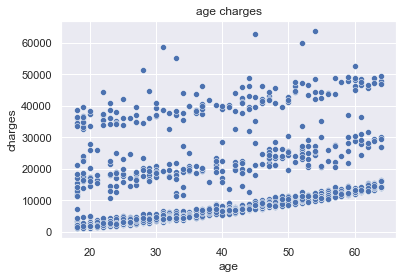

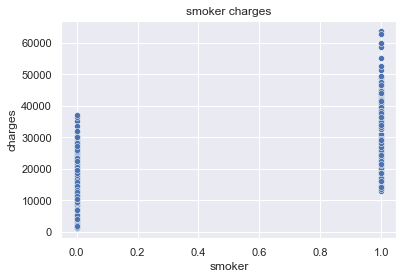

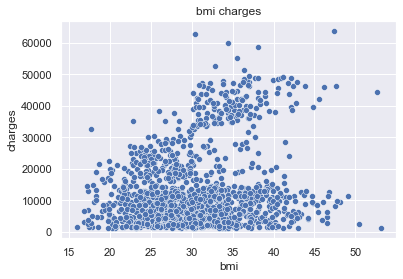

In [74]:
age_charges = sns.scatterplot(insurance_df["age"], insurance_df["charges"])
age_charges.set_title("age charges")
plt.figure()
smoker_charges = sns.scatterplot(insurance_df["smoker"], insurance_df["charges"])
smoker_charges.set_title("smoker charges")
plt.figure()
bmi_charges = sns.scatterplot(insurance_df["bmi"], insurance_df["charges"])
bmi_charges.set_title("bmi charges")
plt.show()

### Interpretation:

1. BMI: datapoints are extremely far spread out, no pattern recognisable --> pattern of average doesn't represent individuals
    * ==> data can't be modeled
2. age: data points are far spread out, but three main groups are visible which follow the same linear pattern 
    * ==> we can't build a model that certainly predicts the insurance charges based on the age
    * ==> but we can predict the change of charges by modelling the linear pattern of the groups.
3. smokers: data points are far spread out
    * ==> we can't build a model that certainly predicts the insurance charges based on whether someone smokes or not
    * ==> but we can test how well the average changes in charges from not smoking to smoking describe this correlation
    * ==> and we can perform logistic regression to compute the liklyhood of someone smoking based on their insurance charges

## Age charges correlation modelling:

In [62]:
# create new dataset with the mean charges of every age
age_groups = pd.DataFrame({"age":[x for x in range(18, 65)], "mean_charges":[x for x in range(18, 65)]})
for age in range(18, 65):
    data = insurance_df.loc[insurance_df["age"] == age]
    age_groups.loc[[age - 18], ["mean_charges"]] = data["charges"].mean()

Text(0.5, 1.0, 'age mean_charges')

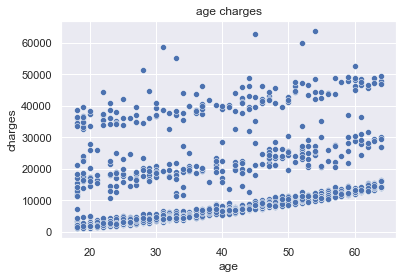

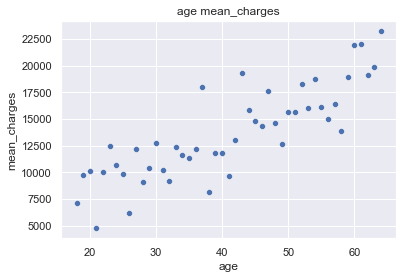

In [63]:
age_charges = sns.scatterplot(insurance_df["age"], insurance_df["charges"])
age_charges.set_title("age charges")
plt.figure()
age_charges = sns.scatterplot(age_groups["age"], age_groups["mean_charges"])
age_charges.set_title("age mean_charges")

pattern mean charges per age has similar slope to the ones of the patterns visible in the original data 

#### Perform linear regression on new dataframe:

In [120]:
x = age_groups["age"].to_numpy()
y = age_groups["mean_charges"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 20) # split in train and  test data

age_reg = LinearRegression() # initialize Linear regression model
age_reg.fit(x_train.reshape(-1, 1), y_train) # fit that model on train data

LinearRegression()

In [121]:
age_reg.score(x_test.reshape(-1, 1), y_test) # evaluate performance of the model

0.7530684073658191

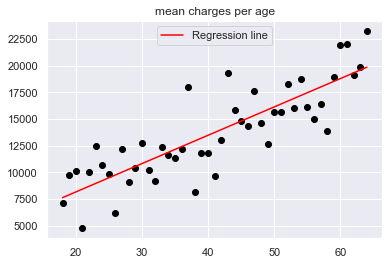

In [122]:
#  regression line visualisation
y_predictions = age_reg.predict(x.reshape(-1, 1))
plt.scatter(age_groups["age"], age_groups["mean_charges"], color="black")
plt.title("mean charges per age")
plt.plot(x, y_predictions, color="red", label="Regression line")
leg = plt.legend(loc='upper center')
plt.show()

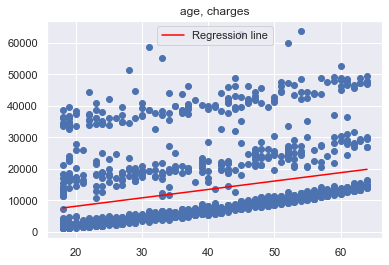

In [123]:
# lay regression line over original data 
plt.scatter(insurance_df["age"], insurance_df["charges"])
plt.title("age, charges")
plt.plot(x, y_predictions, color="red", label="Regression line")
leg = plt.legend(loc='upper center')
plt.show()

### Result:

* linear regression we fit on the mean charges performed quite well with an accuracy of 75 percent, if you take into account the low amount of datapoints
* that models slope fits on the linear pattern of the three different groups visible in the original age charges plot as expected
    * ==> the slope of the model/the change in insurance charges per year can also be applied to individual cases 

#### figure out slope of the regression model:
with m = (y1 - y2)/(x1 - x2)

In [68]:
slope = (age_reg.predict([[60]]) - age_reg.predict([[30]])) / (60-30)
print(slope)

[266.04855468]


* ==> every year people age, raises their medical insurance charges by about 266 dollars

## Smoker charges correlation modelling:

### exploring how well the mean change describes the correlation:

<Figure size 432x288 with 0 Axes>

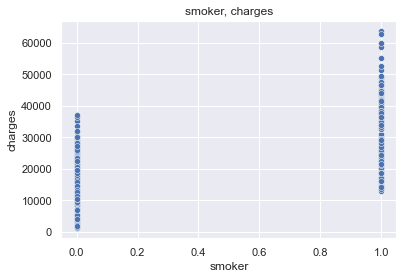

<Figure size 432x288 with 0 Axes>

In [33]:
smoker_charges = sns.scatterplot(insurance_df["smoker"], insurance_df["charges"])
smoker_charges.set_title("smoker, charges")
plt.figure()

In [34]:
#  calculate difference between the mean charges of smoking and not smoking people
mean_charge_non_smoker = insurance_df.loc[insurance_df["smoker"] == 0]["charges"].mean()
mean_charge_smoker = insurance_df.loc[insurance_df["smoker"] == 1]["charges"].mean()
diference = mean_charge_smoker - mean_charge_non_smoker
print(diference)

23615.963533676637


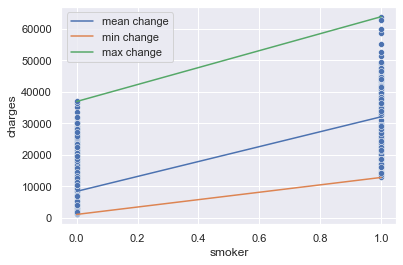

In [35]:
#  visualise that difference and compare with the difference of the minimal and maximal values
sns.scatterplot(insurance_df["smoker"], insurance_df["charges"])
x_values = [0, 1]
y_values = [mean_charge_non_smoker, mean_charge_smoker]
plt.plot(x_values, y_values, label="mean change")
x_values = [0, 1]
y_values = [insurance_df.loc[insurance_df["smoker"] == 0]["charges"].min(), insurance_df.loc[insurance_df["smoker"] == 1]["charges"].min()]
plt.plot(x_values, y_values, label="min change")
x_values = [0, 1]
y_values = [insurance_df.loc[insurance_df["smoker"] == 0]["charges"].max(), insurance_df.loc[insurance_df["smoker"] == 1]["charges"].max()]
plt.plot(x_values, y_values, label="max change")
leg = plt.legend(loc='upper left')
plt.show()

printed minimal and maximal change together with mean change to see how similar they are

#### Result:

* average change of medical insurance charges isn't describing individual cases as well as expected
* However, it still can be applied to get an idea of the drastic influence smoking has on medical insurance charges



### performing logistic regression:
training model:

In [149]:
x = insurance_df["charges"].to_numpy()
y = insurance_df["smoker"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 20) # split in train and  test data

clf = LogisticRegression(random_state=3)
clf.fit(x_train.reshape(-1, 1), y_train)
accuracy = clf.score(x_test.reshape(-1, 1), y_test)
print(f"model reached an accuracy of {accuracy}")

model reached an accuracy of 0.8959276018099548


visualising model:

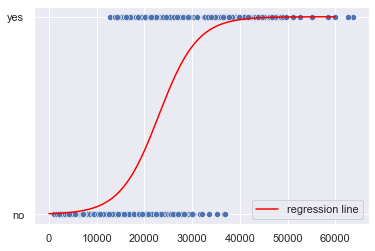

In [152]:
sns.scatterplot(x, y)

x_visualize = np.array([i for i in range(60000)])
y_visualise = clf.predict_proba(x_visualize.reshape(-1, 1))
sns.lineplot(x_visualize, [array[0] for array in y_visualise], color="red", label="regression line")

plt.show()

#### Result:
* Logistic Regression was performed succesfull with an achieved accuracy of 0.9
* That shows that theres a strong correlation between smoking and medical insurance cost


# Project Summary:

This project was meant to find and model the main influences on medical insurance charges. Introducing our dataset to matplotlib and seaborn plots and further analysing it with pandas and numpy allowed us to find out if our data was representative in all categories. This allowed us to make sure that our findings could be transferred to a broader population even tho the dataset is fairly small with just 1338 samples. Once finding our data was representative in all aspects we proceeded to find the associations between these variables. After noticing that the variables age, smoking and BMI had the most visible impact on medical insurance charges we took a closer look at these correlations on our approach to model them. The data points of the BMI charge correlation turned out to be extremely far spread out and the pattern visible in the averages could not be applied to them, which made modelling the data extremely unpractical. The influence of the age and smoker variables on the medical insurance charges also did not follow a single linear pattern, however, they showed recurring patterns similar to those of their averages which made it possible to model their average while still being able to transfer parts of these models to individual cases. The linear regression approach to model the average charge per age lead to an accuracy of 75% which is likely because of the small sample size. The slope of that model provided a fairly accurate representation of the amount an individual would likely pay more for each year that passes(266 USD). Lastly, we tried the same approach of using the average charges to model the influence of the smoking variable, which turned out to not be as accurate as expected. But by additionally computing its minimum and maximum changes in insurance charge, we can infer that the medical insurance charge drastically increases in practically every case when smoking, the only variance is visible in the amount it increases(from 10000 USD to over 20000 USD). The Logistic regression approach however was succesfull, achieving an accuracy of 0.9 when it comes to predicting wether someone is smoking or not based on his insurance charges.